# Module 1.1: RSA calibration

by _Benjamin Delory_,  _Guillaume Lobet_, and _Andrea Schnepf_

## Benchmark

This Jupyter Notebook contains the data analysis pipeline for Module 1.1 (RSA calibration). 

In the context of our collaborative comparison framework, all root architecture models being compared are parameterized using a common set of metrics derived from 2D images of dicotyledonous (_Lupinus albus_) and monocotyledonous (_Zea mays_) root systems. Our root architecture benchmarking dataset contains two distinct sets of images:
- [Images of lupine roots grown for 11 days in an aeroponic setup](https://github.com/RSA-benchmarks/collaborative-comparison/tree/master/root_architecture/img/dicot/lupin) (Lobet et al, 2011)
- [Images of maize roots grown for 8 days on filter papers](https://github.com/RSA-benchmarks/collaborative-comparison/tree/master/root_architecture/img/monocot/maize) (Hund et al, 2009)

All images were analysed using the semi-automated root image analysis software [SmartRoot](https://smartroot.github.io/) (Lobet et al, 2011) and root tracings were saved as [RSML](https://rootsystemml.github.io/) (Lobet et al, 2015) files for further analysis.

In Module 1.1, modellers simulate root systems for the same duration as our ground truth experimental data (i.e., 11 days for lupine and 8 days for maize). Additional information is provided in Table 1 of the supporting paper.

_**The aim of this first benchmarking exercise is to determine if root architecture models currently available are able to reproduce realistic root architectures based on a parameter set derived from experimental data.**_

For this benchmark scenario, **two data analysis pipelines** are used to compare simulation outputs with ground truth experimental data (reference root systems).

**Pipeline 1**: _Comparison of traits computed at the root system level between simulated and reference root systems_

1. Identifying key morphological, architectural, and topological (Fitter indices) traits explaining differences between simulated and reference root systems using multivariate data analysis techniques (e.g., principal component analysis)

2. Looking at when simulated and reference root systems start to diverge/converge with regard to the key root system traits identified in step 1 and how large these differences are

3. Assessing the degree of dissimilarity between simulated and reference root systems using dissimilarity metrics

**Pipeline 2**: _Comparing dissimilarities in architecture between simulated and reference root systems using persistent homology analysis_

1. Computing a persistence barcode for each simulated and reference root system using a geodesic distance function

2. Computing dissimilarities between persistence barcodes using a bottleneck distance

3. Visualizing dissimilarities between root systems using multidimensional scaling

4. Testing specific hypotheses (e.g., PERMANOVA)


## Requirements

To run the code, IRkernel must be installed.

The code provided in this Jupyter Notebook relies on the functions of the archiDART R package. More information about this package can be found in [Delory et al (2016)](https://link.springer.com/article/10.1007/s11104-015-2673-4) and [Delory et al (2018)](https://f1000research.com/articles/7-22/v1).

## Install the R packages needed for the analysis

This step is only necessary if the R packages are not available.

1. Open Anaconda Prompt
2. Type "R" and press "Enter"
3. Execute: `install.packages(c("ggplot2", "gtools", "vegan", "FactoMineR", "devtools", "TDA", "geometry", "sp"))`
4. You can check that the packages have been correctly installed by executing `.packages(all.available=TRUE)`
5. Close R using `q()`

## Load R packages

In [1]:
# These packages are needed for this notebook. Additional packages can also be loaded as well.
library(ggplot2)
library(gtools)
library(vegan)
library(FactoMineR)
library(TDA)
library(geometry)
library(sp)

Loading required package: permute

Attaching package: 'permute'

The following object is masked from 'package:gtools':

    permute

Loading required package: lattice
This is vegan 2.4-4
Loading required package: magic
Loading required package: abind


## Install and load archiDART

Although archiDART is available on [CRAN](https://cran.r-project.org/package=archiDART), the latest version (under development) is available on [GitHub](https://github.com/archidart/archidart). To install archiDART from GitHub (this is the recommended version for this notebook), use the following code:

In [2]:
#This command installs archiDART from its GitHub repository (remove the hashtag in front of "devtools" to install the package)
devtools::install_github("archidart/archidart")
library(archiDART) #This command loads the archiDART package

from URL https://api.github.com/repos/archidart/archidart/zipball/master
Installing archiDART
"C:/Users/benjamindelory/AppData/Local/conda/conda/envs/mro_env/lib/R/bin/x64/R"  \
  --no-site-file --no-environ --no-save --no-restore --quiet CMD INSTALL  \
  "C:/Users/benjamindelory/AppData/Local/Temp/Rtmp8sm7Uk/devtools1dd06bc3765b/archidart-archidart-7bcbcfd"  \
  --library="C:/Users/benjamindelory/Documents/R/win-library/3.4"  \
  --install-tests 



## Install and load postarchiDART

postarchiDART is an R package containing functions developped for the post-processing of R objects created by archiDART functions. The functions of this package were created to perform the following tasks: correct root and plant identification numbers, correct root growth rate values, and correct the branching order of basal roots. These functions are only used on R objects created from RSML files exported by SmartRoot after tracing roots on reference images. To install postarchiDART from [GitHub](https://github.com/archidart/archidart-utilities/tree/master/postarchidart), use the following code:

In [3]:
#This command installs post archiDART from its GitHub repository (remove the hashtag in front of "devtools" to install the package)
#devtools::install_github("archidart/archidart-utilities/postarchidart")
library(postarchiDART) #This command loads the postarchiDART package

## Set working directory to GitHub repository containing "collaborative-comparison"

In [4]:
setwd("C:/Users/benjamindelory/Documents/GitHub")

## Import RSML for reference images

This can be done using the `rsmlToTable`function of archiDART.

`rsmlToTable`creates a data frame (rsmlToTable object). Each line of the data frame gives the attributes of 1 segment (e.g., length, orientation, spatial coordinates, etc.).

In [5]:
###########################
#Load RSML files for dicot
###########################

dicot<-rsmlToTable(inputrsml="collaborative-comparison/root_architecture/img/dicot/lupin", unitlength="cm",
                   rsml.connect=TRUE, rsml.date=NULL, unitangle="d", fitter=FALSE, show.progress=TRUE)

dicot<-correctPlantID(dicot) #Correct plant ID number

#############################
#Load RSML files for monocot
#############################

monocot<-rsmlToTable(inputrsml="collaborative-comparison/root_architecture/img/monocot/maize", unitlength="cm",
                     rsml.connect=TRUE, rsml.date=NULL, unitangle="d", fitter=FALSE, show.progress=TRUE)

Number of rsml files in inputrsml: 9


  |======================================================================| 100%

Number of rsml files in inputrsml: 24


  |======================================================================| 100%

## Give a name to the RSA models to be compared

In [6]:
#Create one object for each RSA model
mod1<-"archisimple"
mod2<-"crootbox"
#Etc.

## Import RSML for simulated root systems

In [17]:
#Set paths to RSML for simulated root systems
#Create one path for each combination of RSA model and plant species simulated

#################################
#Set paths for dicot simulations
#################################

path1.dicot<-"collaborative-comparison/root_architecture/results/b1/dicot/lupin/archisimple" #Path for archisimple simulations for dicot
path2.dicot<-"collaborative-comparison/root_architecture/results/b1/dicot/lupin/crootbox" #Path for crootbox simulations for dicot
#Add one path for each model

##################################
#Set paths for monocot simulations
##################################

path1.monocot<-"collaborative-comparison/root_architecture/results/b1/monocot/maize/archisimple" #Path for archisimple simulations for monocot
path2.monocot<-"collaborative-comparison/root_architecture/results/b1/monocot/maize/crootbox" #Path for crootbox simulations for monocot
#Add one path for each model

######################################################################################################################
#If the root system age is stored as a continuous function along the root segments, what is the name of that function?
######################################################################################################################

#age<-"NAME_OF_THE_FUNCTION"
age<-"emergence_time"

###########################
#What is the vertical axis?
###########################

vertical<-"z"

####################################
#Import RSML for dicot root systems
####################################

#mod1.dicot<-rsmlToTable(inputrsml=paste(getwd(), path1.dicot, sep="/"), unitlength="cm", rsml.connect=TRUE, 
                        #rsml.date=age, unitangle="d", fitter=FALSE, show.progress=TRUE, vertical3d=vertical)

mod2.dicot<-rsmlToTable(inputrsml=paste(getwd(), path2.dicot, sep="/"), unitlength="cm", rsml.connect=TRUE, 
                        rsml.date=age, unitangle="d", fitter=FALSE, show.progress=TRUE, vertical3d=vertical)

#Etc.

#####################################
#Import RSML for monocot root systems
#####################################

#mod1.monocot<-rsmlToTable(inputrsml=paste(getwd(), path1.monocot, sep="/"), unitlength="cm", rsml.connect=TRUE, 
                          #rsml.date=age, unitangle="d", fitter=FALSE, show.progress=TRUE, vertical3d=vertical)

mod2.monocot<-rsmlToTable(inputrsml=paste(getwd(), path2.monocot, sep="/"), unitlength="cm", rsml.connect=TRUE, 
                          rsml.date=age, unitangle="d", fitter=FALSE, show.progress=TRUE, vertical3d=vertical)

#Etc.

Number of rsml files in inputrsml: 5


  |                                                                      |   0%

No time unit found in crootbox-1 metadata (property-definition)


  |==================                                                    |  25%

No time unit found in crootbox-2 metadata (property-definition)


  |===================================                                   |  50%

No time unit found in crootbox-3 metadata (property-definition)


  |====================================================                  |  75%

No time unit found in crootbox-4 metadata (property-definition)


  |======================================================================| 100%

No time unit found in crootbox-5 metadata (property-definition)
Number of rsml files in inputrsml: 5


  |                                                                      |   0%

No time unit found in crootbox-1 metadata (property-definition)


  |==================                                                    |  25%

No time unit found in crootbox-2 metadata (property-definition)


  |===================================                                   |  50%

No time unit found in crootbox-3 metadata (property-definition)


  |====================================================                  |  75%

No time unit found in crootbox-4 metadata (property-definition)


  |======================================================================| 100%

No time unit found in crootbox-5 metadata (property-definition)


## Pipeline 1: _Comparison of traits computed at the root system level between simulated and reference root systems_

### 1.1. Identifying key morphological, architectural, and topological traits explaining differences between simulated and reference root systems

In archiDART, the `architect` function can be used to compute root system traits. For each root system and each observation date, the following parameters will be calculated:

- **TRL**: total root length
- **GRTR**: growth rate of the root system
- **L1R**: first-order root length
- **GR1R**: first-order root growth rate
- **TN1R**: total number of first-order roots
- **TNLR**: total number of lateral roots
- **TLRL**: total lateral root length
- **NxLR**: total number of lateral roots with a branching order equal to x
- **LxLR**: total length of lateral roots with a branching order equal to x
- **MLxLR**: mean length of lateral roots with a branching order equal to x
- **GRxL**: growth rate of roots with a branching order equal to x
- **D2LR**: density of secondary roots on first-order roots
- **Height**: root system height
- **Width**: root system width
- **Convexhull**: area of the convex hull
- **Magnitude**: the magnitude of the root system (Fitter, 1986, 1987)
- **Altitude**: the altitude of the root system (Fitter, 1986, 1987)
- **ExtPathLength**: the total exterior path length of the root system (Fitter, 1986, 1987)

If diameter values are provided in the RSML files, the following parameters will be calculated for each root system at the last observation date:

- **MDx**: mean diameter of roots with a branching order equal to x
- **MDLR**: mean lateral root diameter
- **Sx**: total surface area of roots with a branching order equal to x
- **Stot**: total root surface area
- **Vx**: total volume of roots with a branching order equal to x
- **Vtot**: the root system volume

The rsmlToTable objects created earlier can directly be used as an input of the `architect` function. Root system traits can be calculated using the following code:

In [18]:
######################################################
#Compute root system traits for reference root systems
######################################################

#For the dicot
plant.dicot<-architect(inputrsml=dicot, fitter=TRUE)
plant.dicot$Time<-as.numeric(sapply(strsplit(sapply(strsplit(plant.dicot$FileName, split="_"), "[[", 2), split="d"), "[[", 2))
plant.dicot<-plant.dicot[order(plant.dicot$Time, plant.dicot$FileName),]
plant.dicot<-correctGrowthRateDicot(plant.dicot)
plant.dicot$model<-"reference"

#For the monocot
plant.monocot<-architect(inputrsml=monocot, fitter=TRUE)
plant.monocot<-correctFirstOrderRoots(x=monocot, y=plant.monocot)
plant.monocot$Time<-rep(1:8, 3)
plant.monocot<-plant.monocot[order(plant.monocot$Time, plant.monocot$FileName),]
plant.monocot<-correctGrowthRateMonocot(plant.monocot)
plant.monocot$model<-"reference"

######################################################
#Compute root system traits for simulated root systems
######################################################

#For the dicot
#plant.mod1.dicot<-architect(inputrsml=mod1.dicot, vertical3d=vertical, fitter=TRUE)
#plant.mod1.dicot$model<-mod1
plant.mod2.dicot<-architect(inputrsml=mod2.dicot, vertical3d=vertical, fitter=TRUE)
plant.mod2.dicot$model<-mod2
#Etc.

#For the monocot
#plant.mod1.monocot<-architect(inputrsml=mod1.monocot, vertical3d=vertical, fitter=TRUE)
#plant.mod1.monocot$model<-mod1
plant.mod2.monocot<-architect(inputrsml=mod2.monocot, vertical3d=vertical, fitter=TRUE)
plant.mod2.monocot$model<-mod2
#Etc.

We will now use **principal component analysis (PCA)** to identify the root system traits explaining the greatest amount of variation between simulated root systems. To do this, we first need to create new objects containing root system traits calculated at the last observation date (11 days for lupin and 8 days for maize). We can do this using the following code:

Warning message in arrows(0, 0, coord.var[v, 1], coord.var[v, 2], length = 0.1, :
"zero-length arrow is of indeterminate angle and so skipped"

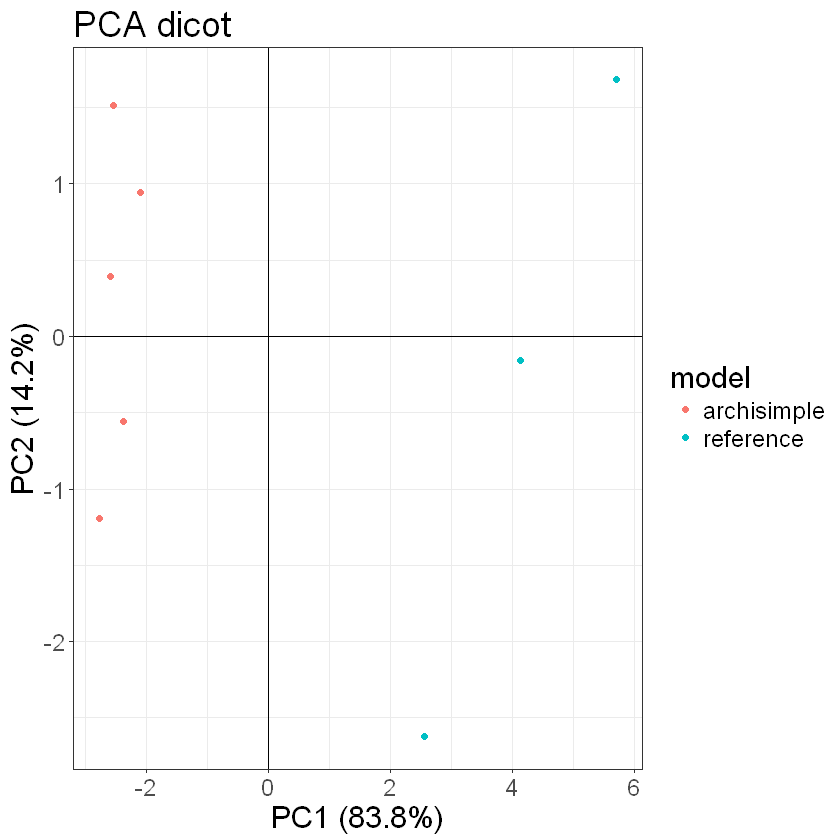

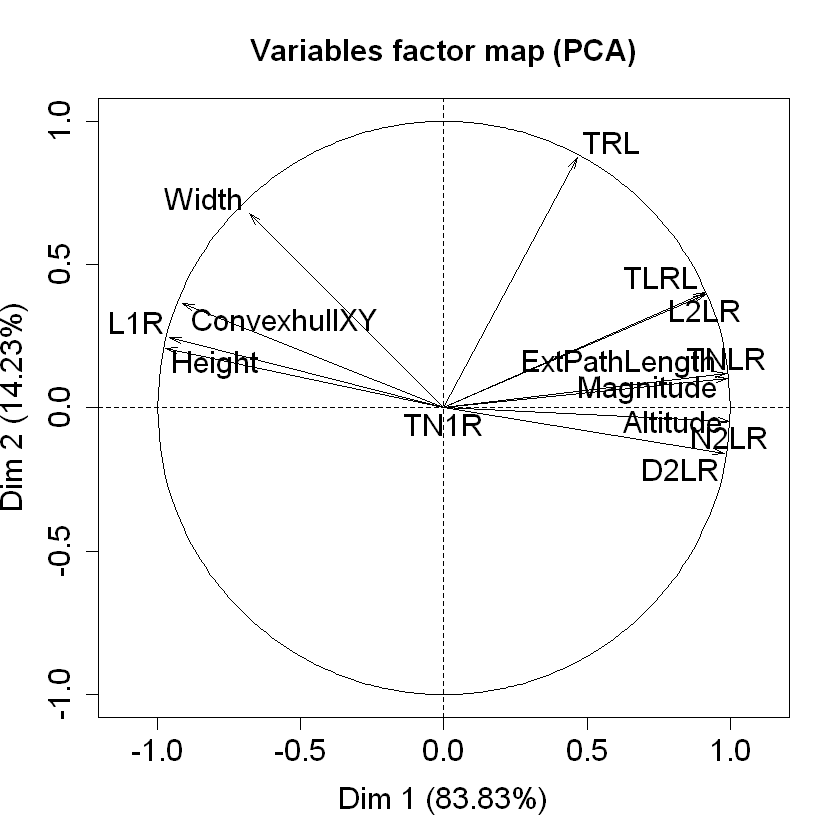

In [12]:
#In rsml from reference images, y is the vertical axis by default
#If z is the vertical axis of simulated root systems, then ConvexhullXY in plant.dicot becomes ConvexhullXZ

if (vertical=="z"){plant.dicot$ConvexhullXZ<-plant.dicot$ConvexhullXY}

#######################
#Create table for dicot
#######################

#datadicot<-smartbind(plant.dicot, plant.mod1.dicot, plant.mod2.dicot) #Add more objects if needed
datadicot<-smartbind(plant.dicot, plant.mod1.dicot)
datadicot<-datadicot[datadicot$Time==11,] #Select traits measured at the last observation date

#################
#Do PCA for dicot
#################

#Select variables for PCA
if (vertical=="y"){
    datapca<-datadicot[,c("TRL", "L1R", "TN1R", "TNLR", "TLRL", "N2LR", "L2LR", "D2LR", "Height", "Width", "ConvexhullXY",
                          "Magnitude", "Altitude", "ExtPathLength", "model")]}

if (vertical=="z"){
    datapca<-datadicot[,c("TRL", "L1R", "TN1R", "TNLR", "TLRL", "N2LR", "L2LR", "D2LR", "Height", "Width", "ConvexhullXZ",
                          "Magnitude", "Altitude", "ExtPathLength", "model")]}

#PCA dicot
pca<-PCA(datapca, scale.unit=TRUE, ncp=3, quali.sup=which(colnames(datapca)=="model"), graph=FALSE)
indpca<-as.data.frame(pca$ind$coord)
indpca<-as.data.frame(lapply(indpca, function(x) as.numeric(as.character(x))))
indpca$model<-datadicot$model

#Plot PCA dicot
ggplot(indpca)+
geom_point(aes(Dim.1, Dim.2, colour=model))+
xlab(paste("PC1 (", round(pca$eig[1,2], 1), "%)", sep=""))+
ylab(paste("PC2 (", round(pca$eig[2,2], 1), "%)", sep=""))+
ggtitle("PCA dicot")+
geom_hline(yintercept=0)+
geom_vline(xintercept=0)+
theme_bw()+
theme(axis.title=element_text(size=18), text=element_text(size=18))

#Plot correlation circle
par(ps = 18, cex = 1, cex.main = 1)
plot(pca, choix="var")

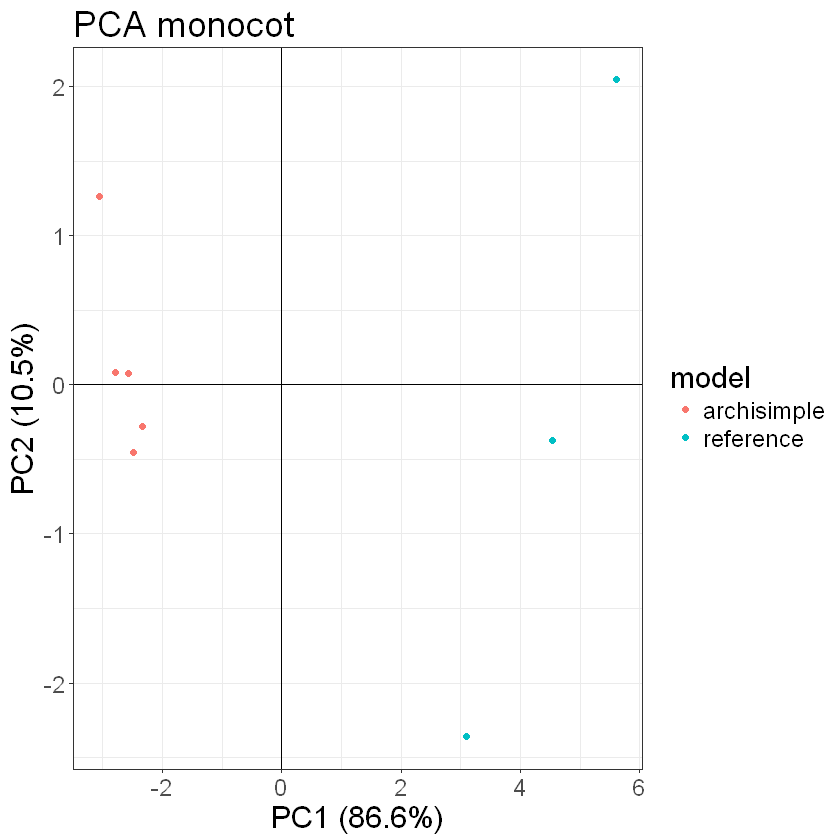

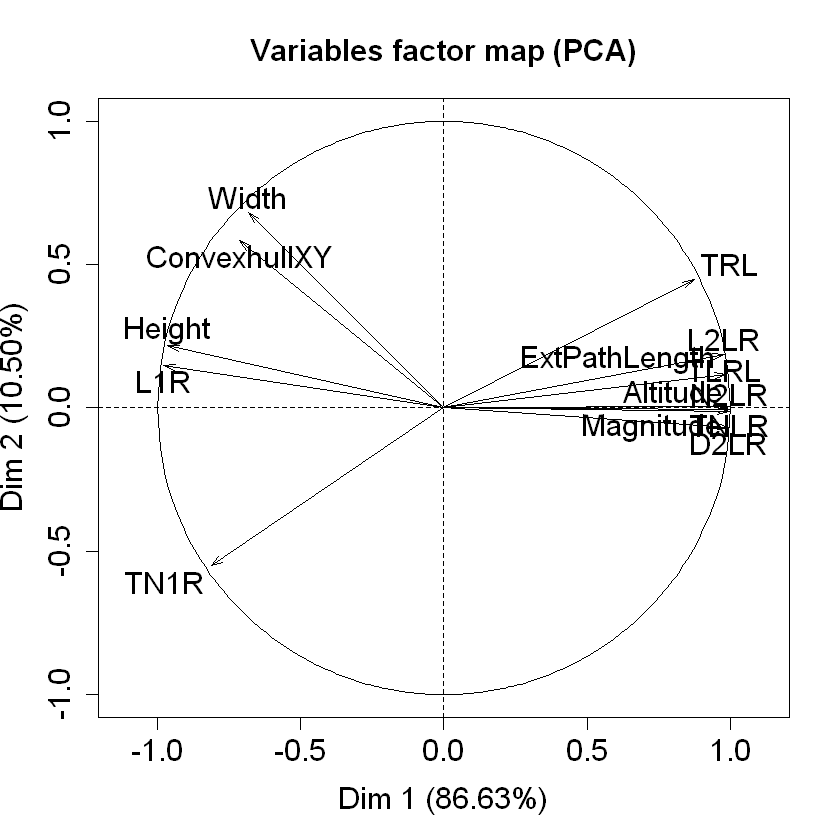

In [13]:
#In rsml from reference images, y is the vertical axis by default
#If z is the vertical axis of simulated root systems, then ConvexhullXY in plant.monocot becomes ConvexhullXZ

if (vertical=="z"){plant.monocot$ConvexhullXZ<-plant.monocot$ConvexhullXY}

#########################
#Create table for monocot
#########################

#datamonocot<-smartbind(plant.monocot, plant.mod1.monocot, plant.mod2.monocot) #Add more objects if needed
datamonocot<-smartbind(plant.monocot, plant.mod1.monocot)
datamonocot<-datamonocot[datamonocot$Time==8,] #Select traits measured at the last observation date

####################
#Do PCA for monocot
####################

#Select variables for PCA
if (vertical=="y"){
    datapca<-datamonocot[,c("TRL", "L1R", "TN1R", "TNLR", "TLRL", "N2LR", "L2LR", "D2LR", "Height", "Width", "ConvexhullXY",
                            "Magnitude", "Altitude", "ExtPathLength", "model")]}

if (vertical=="z"){
    datapca<-datamonocot[,c("TRL", "L1R", "TN1R", "TNLR", "TLRL", "N2LR", "L2LR", "D2LR", "Height", "Width", "ConvexhullXZ",
                            "Magnitude", "Altitude", "ExtPathLength", "model")]}

#PCA monocot
pca<-PCA(datapca, scale.unit=TRUE, ncp=3, quali.sup=which(colnames(datapca)=="model"), graph=FALSE)
indpca<-as.data.frame(pca$ind$coord)
indpca<-as.data.frame(lapply(indpca, function(x) as.numeric(as.character(x))))
indpca$model<-datamonocot$model

#Plot PCA monocot
ggplot(indpca)+
geom_point(aes(Dim.1, Dim.2, colour=model))+
xlab(paste("PC1 (", round(pca$eig[1,2], 1), "%)", sep=""))+
ylab(paste("PC2 (", round(pca$eig[2,2], 1), "%)", sep=""))+
ggtitle("PCA monocot")+
geom_hline(yintercept=0)+
geom_vline(xintercept=0)+
theme_bw()+
theme(axis.title=element_text(size=18), text=element_text(size=18))

#Plot correlation circle
par(ps = 18, cex = 1, cex.main = 1)
plot(pca, choix="var")

### 1.2. Looking at when simulated and reference root systems start to diverge/converge with regard to the key root system traits identified in step 1 and how large these differences are

In [14]:
plant.dicot$FileName<-paste("lupin_", sapply(strsplit(plant.dicot$FileName, split="_"), "[[", 3))
if (vertical=="z"){plant.dicot$ConvexhullXY<-NA}
#datadicot<-smartbind(plant.dicot, plant.mod1.dicot, plant.mod2.dicot) #Add more objects if needed
datadicot<-smartbind(plant.dicot, plant.mod1.dicot)

In [ ]:
#####################
#Plot trait for dicot
#####################

#Plot results for all simulations
ggplot(datadicot[datadicot$Time<=11,])+
geom_line(aes(x=Time, y=TRL, colour=model, group=FileName), size=2)+
xlab("Time (days)")+
ylab("Total root length (cm)")+
theme_bw()+
theme(axis.title=element_text(size=18), text=element_text(size=18))

#Plot average per simulation
ggplot(datadicot[datadicot$Time<=11,])+
stat_smooth(aes(x=Time, y=TRL, colour=model), size=2)+
xlab("Time (days)")+
ylab("Total root length (cm)")+
theme_bw()+
theme(axis.title=element_text(size=18), text=element_text(size=18))

In [ ]:
plant.monocot$FileName<-sapply(strsplit(plant.monocot$FileName, split="_"), "[[", 1)
#datamonocot<-smartbind(plant.monocot, plant.mod1.monocot, plant.mod2.monocot) #Add more objects if needed
datamonocot<-smartbind(plant.monocot, plant.mod1.monocot)

In [ ]:
########################
#Plot trait for monocot
########################

#Plot results for all simulations
ggplot(datamonocot[datamonocot$Time<=8,])+
geom_line(aes(x=Time, y=TRL, colour=model, group=FileName), size=2)+
xlab("Time (days)")+
ylab("Total root length (cm)")+
theme_bw()+
theme(axis.title=element_text(size=18), text=element_text(size=18))

#Plot average per simulation
ggplot(datamonocot[datamonocot$Time<=8,])+
stat_smooth(aes(x=Time, y=TRL, colour=model), size=2)+
xlab("Time (days)")+
ylab("Total root length (cm)")+
theme_bw()+
theme(axis.title=element_text(size=18), text=element_text(size=18))

### 1.3. Assessing the degree of dissimilarity between simulated and reference root systems using dissimilarity metrics

The deviation between model predictions and ground truth experimental data will be quantified using performance measures listed in Table 1 of [Janssen and Heuberger (1995)](https://www.sciencedirect.com/science/article/pii/0304380095000849).

## Pipeline 2: _Comparing dissimilarities in architecture between simulated and reference root systems using persistent homology analysis_

### 2.1. Computing a persistence barcode for each simulated and reference root system using a geodesic distance function

Persistent homology is a mathematical framework allowing the topological analysis of branching structures, such as shoot and root systems. Recently, a new data analysis pipeline was implemented in archiDART to analyse root system architectures using persistent homology. More information can be found in [Li et al (2017)](https://onlinelibrary.wiley.com/doi/abs/10.3732/ajb.1700046) and [Delory et al (2018)](https://f1000research.com/articles/7-22/v1).

The main output of a persistent homology analysis is a persistence barcode recording the birth (apparition of a new connected component) and death (fusion of two connected components) of each branch when a distance function traverses the branching structure. For a given mathematical function, one persistence barcode can be computed for each simulated root system. Look at Figure 1 and interactive Figure 3 [in this paper](https://f1000research.com/articles/7-22/v1) for a more accurate description of a persistence barcode. Barcodes can be computed using the following code:

In [ ]:
#######################################
#Compute persistence barcodes for dicot
#######################################

#table.dicot<-rbind(dicot[dicot$file=="lupin_d11",], mod1.dicot, mod2.dicot) #Add rsmlToTable objects if necessary
table.dicot<-rbind(dicot[dicot$file=="lupin_d11",], mod1.dicot)
ph.dicot<-perhomology(table.dicot, show.progress=TRUE)

#########################################
#Compute persistence barcodes for monocot
#########################################

#table.monocot<-rbind(monocot[monocot$file=="PL01_DAS08"|monocot$file=="PL08_DAS08"|monocot$file=="PL10_DAS08",], mod1.monocot, mod2.monocot) #Add rsmlToTable objects if necessary
table.monocot<-rbind(monocot[monocot$file=="PL01_DAS08"|monocot$file=="PL08_DAS08"|monocot$file=="PL10_DAS08",], mod1.monocot) #Add rsmlToTable objects if necessary
ph.monocot<-perhomology(table.monocot, show.progress=TRUE)

### 2.2. Computing dissimilarities between persistence barcodes using a bottleneck distance

To compare persistence barcodes against each other, a pairwise distance matrix is needed and the bottleneck distance is one possible option. The **bottleneck distance** is considered as a robust dissimilarity metric between two persistence barcodes, and its interpretation is quite straightforward: the greater the distance between two persistence barcodes, the greater will be the dissimilarity between them. Such pairwise bottleneck distance matrix can be calculated with the `bottleneckdist` function of the archiDART package. This function only requires a perhomology object as an input. It has to be noted that the computation time required to compute a bottleneck distance matrix is highly dependent on the number and complexity of root systems being compared.

In [ ]:
#############################################
#Compute bottleneck distance matrix for dicot
#############################################

distance.dicot<-bottleneckdist(ph.dicot, show.progress=TRUE)

###############################################
#Compute bottleneck distance matrix for monocot
###############################################

distance.monocot<-bottleneckdist(ph.monocot, show.progress=TRUE)

### 2.3. Visualizing dissimilarities between root systems using multidimensional scaling

In [ ]:
###################################
#Multidimensional scaling for dicot
###################################

#k is the number of dimensions
k<-3
mds.dicot<-cmdscale(distance.dicot, k=k, eig=TRUE, add=TRUE)

#Evaluate quality of representation using a Shepard plot
realdist<-as.vector(as.dist(distance.dicot))
confdist<-as.vector(dist(mds.dicot$points))
par(ps=18, cex=1, cex.main=1)
plot(realdist, confdist, xlab="Real distances", ylab="Distances in configuration", pch=16, main="Shepard plot", las=1)
abline(a=0, b=1, col="red", lwd=2)

#Plot MDS for dicot
model<-datadicot[datadicot$Time==11, "model"]
datamds<-data.frame(mds.dicot$points, model=model)
colnames(datamds)<-c(paste(rep("MDS", k), c(1:k), sep=""), "model")

ggplot(datamds)+
geom_point(aes(MDS1, MDS2, colour=model))+
geom_hline(yintercept=0)+
geom_vline(xintercept=0)+
ggtitle("Metric multidimensional scaling")+
xlab("MDS1")+
ylab("MDS2")+
theme_bw()+
theme(axis.title=element_text(size=18), text=element_text(size=18))

In [ ]:
#####################################
#Multidimensional scaling for monocot
#####################################

#k is the number of dimensions
k<-3
mds.monocot<-cmdscale(distance.monocot, k=k, eig=TRUE, add=TRUE)

#Evaluate quality of representation using a Shepard plot
realdist<-as.vector(as.dist(distance.monocot))
confdist<-as.vector(dist(mds.monocot$points))
par(ps=18, cex=1, cex.main=1)
plot(realdist, confdist, xlab="Real distances", ylab="Distances in configuration", pch=16, main="Shepard plot", las=1)
abline(a=0, b=1, col="red", lwd=2)

#Plot MDS for dicot
model<-datamonocot[datamonocot$Time==8, "model"]
datamds<-data.frame(mds.monocot$points, model=model)
colnames(datamds)<-c(paste(rep("MDS", k), c(1:k), sep=""), "model")

ggplot(datamds)+
geom_point(aes(MDS1, MDS2, colour=model))+
geom_hline(yintercept=0)+
geom_vline(xintercept=0)+
ggtitle("Metric multidimensional scaling")+
xlab("MDS1")+
ylab("MDS2")+
theme_bw()+
theme(axis.title=element_text(size=18), text=element_text(size=18))

### 2.4. Testing specific hypotheses

In [ ]:
################
#PERMANOVA dicot
################

permanova.dicot<-adonis(as.dist(distance.dicot)~model, data=data.frame(file=rownames(distance.dicot), model=model),
                        permutations = 10000, sqrt.dist=TRUE)
permanova.dicot

#Chech PERMANOVA assumption (multivariate homogeneity of group dispersions)
bd<-betadisper(as.dist(distance.dicot), model)
par(ps=18, cex=1, cex.main=1)
boxplot(bd)
permutest(bd, permutations=1000)

In [ ]:
##################
#PERMANOVA monocot
##################

permanova.monocot<-adonis(as.dist(distance.monocot)~model, data=data.frame(file=rownames(distance.monocot), model=model), 
                          permutations = 10000, sqrt.dist=TRUE)
permanova.monocot

#Chech PERMANOVA assumption (multivariate homogeneity of group dispersions)
bd<-betadisper(as.dist(distance.monocot), model)
par(ps=18, cex=1, cex.main=1)
boxplot(bd)
permutest(bd, permutations=1000)

## References

Delory, B. M., Baudson, C., Brostaux, Y., Lobet, G., du Jardin, P., Pagès, L., and Delaplace,P. (2016). [archiDART: an R package for the automated computation of plant root architectural traits](https://link.springer.com/article/10.1007/s11104-015-2673-4). _Plant and Soil_, 398(1):351–365.

Delory, B. B. M., Li, M., Topp, C. C. N., and Lobet, G. (2018). [archiDART v3.0: A new data analysis pipeline allowing the topological analysis of plant root systems](https://f1000research.com/articles/7-22/v1). _F1000Research_, 7:22.

Fitter, A.H. (1986). [The topology and geometry of plant root systems: influence of watering rate on root system topology in _Trifolium pratense_](https://academic.oup.com/aob/article/58/1/91/174778). _Annals of Botany_, 58(1):91–101.

Fitter, A.H. (1987). [An architectural approach to the comparative ecology of plant root systems](https://nph.onlinelibrary.wiley.com/doi/abs/10.1111/j.1469-8137.1987.tb04683.x). _New Phytologist_, 106(s1):61–77.

Hund, A., Trachsel, S., and Stamp, P. (2009). [Growth of axile and lateral roots of maize: Idevelopment of a phenotying platform](https://link.springer.com/article/10.1007/s11104-009-9984-2). _Plant and Soil_, 325(1):335–349.

Janssen, P.H.M. and Heuberger, P.S.C. (1995). [Calibration of process-oriented models](https://www.sciencedirect.com/science/article/pii/0304380095000849). _Ecological Modelling_, 83:55-66.

Lobet, G., Pagès, L., and Draye, X. (2011). [A novel image-analysis toolbox enabling quantitative analysis of root system architecture](http://www.plantphysiol.org/content/157/1/29). _Plant Physiology_, 157:29–39.

Lobet, G., Pound, M. P., Diener, J., Pradal, C., Draye, X., Godin, C., Javaux, M., Leitner, D.,Meunier, F., Nacry, P., Pridmore, T. P., and Schnepf, A. (2015). [Root System Markup Language: toward an unified root architecture description language](http://www.plantphysiol.org/content/167/3/617). _Plant Physiology_, 167:617–627.